# Goal of Analysis

### 1. Classify videos into 3 categories: Hot, stable, and everything else

### 2. what are the main characteristics of hot videos?

### 3. how to use the hot video features from a product view?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
count = pd.read_csv('video_count.csv', parse_dates= ['date'])
count.head()

,video_id,count,date
0,2303,22,2015-01-07
1,1193,54854,2015-01-12
2,1219,1788779,2015-01-03
3,1472,234,2015-01-04
4,2947,14407,2015-01-08


In [3]:
feature = pd.read_csv('video_features.csv', parse_dates= ['video_upload_date'])
feature.head()

,video_id,video_length,video_language,video_upload_date,video_quality
0,2374,1760,Cn,2014-12-06,480p
1,1897,489,Cn,2014-12-10,720p
2,2386,1273,Es,2014-12-05,480p
3,2912,986,Es,2014-12-10,240p
4,2432,1050,Other,2014-12-10,480p


In [4]:
data = pd.merge(left = count, right = feature, on = 'video_id', how = 'left')
data.head()

,video_id,count,date,video_length,video_language,video_upload_date,video_quality
0,2303,22,2015-01-07,1071,Cn,2014-12-10,1080p
1,1193,54854,2015-01-12,770,Other,2014-12-07,720p
2,1219,1788779,2015-01-03,904,Cn,2014-12-12,240p
3,1472,234,2015-01-04,157,Other,2014-12-10,240p
4,2947,14407,2015-01-08,446,Cn,2014-12-19,480p


In [5]:
count.shape, feature.shape, data.shape

((41775, 3), (2785, 5), (41775, 7))

### Qustion 1: extract features and classify videos

In [6]:
# extract time interval information
data['interval'] = (data['date'] - data['video_upload_date']).apply(lambda x: x.days)

# extract video play day of week
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

data.head()

,video_id,count,date,video_length,video_language,video_upload_date,video_quality,interval,dayofweek
0,2303,22,2015-01-07,1071,Cn,2014-12-10,1080p,28,2
1,1193,54854,2015-01-12,770,Other,2014-12-07,720p,36,0
2,1219,1788779,2015-01-03,904,Cn,2014-12-12,240p,22,5
3,1472,234,2015-01-04,157,Other,2014-12-10,240p,25,6
4,2947,14407,2015-01-08,446,Cn,2014-12-19,480p,20,3


In [7]:
def parse_data(df):
    """ function to calculate the statistics for """
    counts = df.sort_values(by='date')['count'].values
    change = (counts[1:] - counts[:-1]) / counts[:-1]
    
    index = ['ct_mean', 'ct_std', 'ct_min', 'ct_25%', 'ct_50%', 'ct_75%', 'ct_max', 
             'cg_mean', 'cg_std', 'cg_min', 'cg_25%', 'cg_50%', 'cg_75%', 'cg_max']
    
    ct_vals = pd.Series(counts).describe()
    cg_vals = pd.Series(change).describe()
    
    ct_values = [ct_vals['mean'], ct_vals['std'], ct_vals['min'], ct_vals['25%'], 
                 ct_vals['50%'], ct_vals['75%'], ct_vals['max']]
    cg_values = [cg_vals['mean'], cg_vals['std'], cg_vals['min'], cg_vals['25%'], 
                 cg_vals['50%'], cg_vals['75%'], cg_vals['max']]
    
    return pd.Series(ct_values + cg_values, index=index)

data_stats = data.groupby('video_id').apply(parse_data)
data_stats.head()

,ct_mean,ct_std,ct_min,ct_25%,ct_50%,ct_75%,ct_max,cg_mean,cg_std,cg_min,cg_25%,cg_50%,cg_75%,cg_max
video_id,,,,,,,,,,,,,,
1,7.063560e+04,39200.460092,19382.0,41099.0,65907.0,96335.0,140460.0,-0.127437,0.092392,-0.271522,-0.186381,-0.151384,-0.067977,0.030277
2,1.737141e+06,114254.355156,1550493.0,1673415.5,1718352.0,1782226.5,2011096.0,-0.014184,0.061794,-0.084904,-0.061459,-0.043876,0.030687,0.095038
3,2.292781e+06,218636.897779,2016210.0,2132336.5,2247587.0,2436222.5,2653063.0,0.008923,0.054069,-0.075863,-0.028293,-0.001068,0.056393,0.097053
4,2.740392e+06,169611.440727,2474228.0,2611162.0,2719547.0,2880268.5,2984146.0,0.011310,0.050495,-0.063991,-0.027125,0.001606,0.050860,0.090804
5,4.479973e+05,237137.305768,169730.0,255574.5,388594.0,609508.0,983058.0,-0.111811,0.107193,-0.269337,-0.177432,-0.133447,-0.012729,0.031766


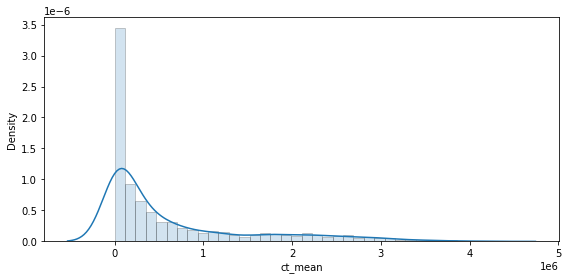

In [8]:
# We then see the Popularity distribution

%matplotlib inline

hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(data_stats['ct_mean'], ax=ax, hist_kws=hist_kws)
plt.tight_layout()
plt.show()

Base on the mean count(ct_mean), we can set some threshold for the stable video: I define it as 1,500,000 or above

In [9]:
# Category: Stable and Popular

popular_video = data_stats[data_stats['ct_mean'] > 1500000]
popular_video.head()

,ct_mean,ct_std,ct_min,ct_25%,ct_50%,ct_75%,ct_max,cg_mean,cg_std,cg_min,cg_25%,cg_50%,cg_75%,cg_max
video_id,,,,,,,,,,,,,,
2,1.737141e+06,114254.355156,1550493.0,1673415.5,1718352.0,1782226.5,2011096.0,-0.014184,0.061794,-0.084904,-0.061459,-0.043876,0.030687,0.095038
3,2.292781e+06,218636.897779,2016210.0,2132336.5,2247587.0,2436222.5,2653063.0,0.008923,0.054069,-0.075863,-0.028293,-0.001068,0.056393,0.097053
4,2.740392e+06,169611.440727,2474228.0,2611162.0,2719547.0,2880268.5,2984146.0,0.011310,0.050495,-0.063991,-0.027125,0.001606,0.050860,0.090804
8,2.049360e+06,157190.210173,1776574.0,1950028.5,2042499.0,2154066.5,2328022.0,0.004013,0.055904,-0.090772,-0.034195,0.009304,0.046501,0.081409
14,1.593414e+06,249941.247042,1301816.0,1380598.0,1502636.0,1793568.0,2056101.0,-0.011086,0.063787,-0.095199,-0.074206,-0.005127,0.049045,0.092254


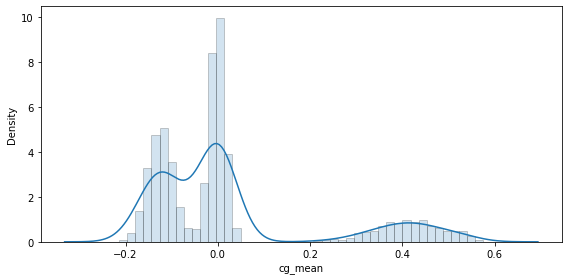

In [10]:
# See the popularity of hot video

fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(data_stats['cg_mean'], ax=ax, hist_kws=hist_kws)
plt.tight_layout()
plt.show()

We can define the threshold for hot video as >20% of the change rate 

In [11]:
# Category: Hot

hot_video = data_stats[data_stats['cg_mean'] > 0.2]
hot_video.head()

,ct_mean,ct_std,ct_min,ct_25%,ct_50%,ct_75%,ct_max,cg_mean,cg_std,cg_min,cg_25%,cg_50%,cg_75%,cg_max
video_id,,,,,,,,,,,,,,
10,8903.133333,10248.629782,591.0,1882.5,5483.0,11318.5,34789.0,0.353819,0.220112,0.006865,0.238332,0.324975,0.416434,0.780195
13,91228.200000,91574.506421,4746.0,16688.0,45930.0,153985.5,264570.0,0.350798,0.223287,-0.000643,0.171082,0.373361,0.514471,0.629066
15,6184.400000,9384.882059,494.0,1190.0,1705.0,6231.5,33208.0,0.381382,0.313682,-0.048170,0.026856,0.471749,0.656678,0.740953
28,105011.600000,132346.803029,6152.0,14399.0,30084.0,152599.5,405278.0,0.367767,0.239208,-0.045739,0.206640,0.300966,0.502638,0.778389
29,78372.866667,70559.053747,9118.0,16789.5,45226.0,131717.0,212419.0,0.271285,0.228626,-0.028478,0.046231,0.293353,0.455947,0.665369


As for everything else, other videos not selected in the above two categories will fall into everything else.

### Question 2. what are the main characteristics of hot videos?

In [12]:
# We first find out what are the hot videos

data['hot'] = False
data.loc[data['video_id'].isin(hot_video.index), 'hot'] = True
data.head()

,video_id,count,date,video_length,video_language,video_upload_date,video_quality,interval,dayofweek,hot
0,2303,22,2015-01-07,1071,Cn,2014-12-10,1080p,28,2,False
1,1193,54854,2015-01-12,770,Other,2014-12-07,720p,36,0,False
2,1219,1788779,2015-01-03,904,Cn,2014-12-12,240p,22,5,False
3,1472,234,2015-01-04,157,Other,2014-12-10,240p,25,6,False
4,2947,14407,2015-01-08,446,Cn,2014-12-19,480p,20,3,True


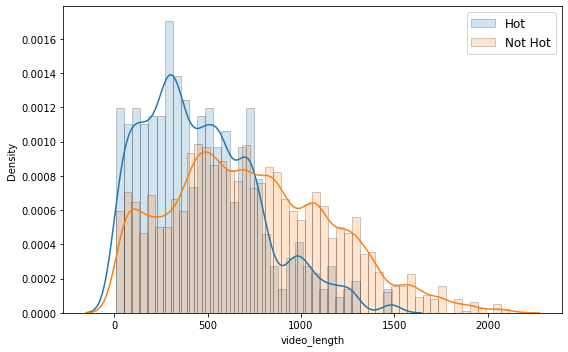

In [13]:
# visualization of length

fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(data[data['hot']==True]['video_length'], label='Hot', ax=ax, hist_kws=hist_kws)
sns.distplot(data[data['hot']==False]['video_length'], label='Not Hot', ax=ax, hist_kws=hist_kws)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

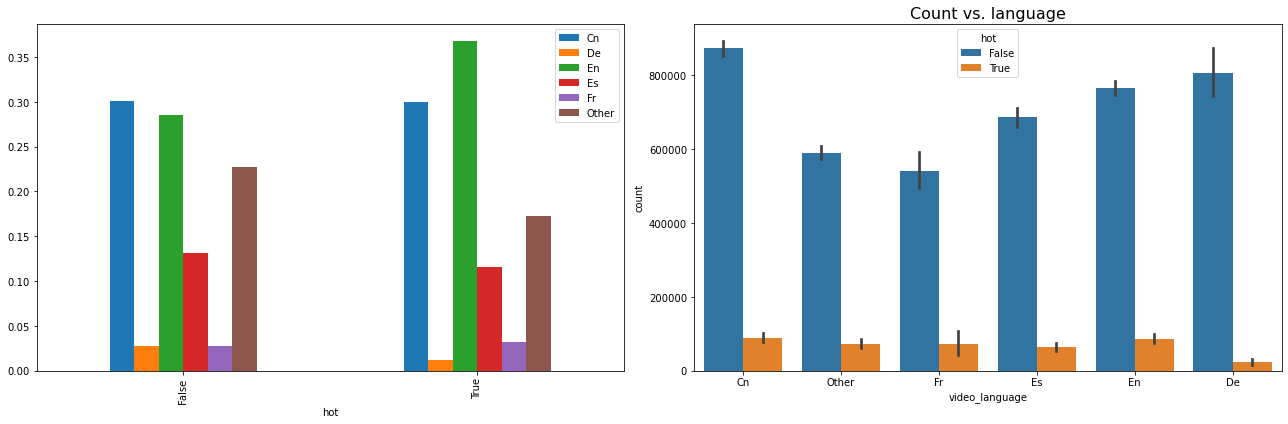

In [14]:
# visualization of language

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
tmp = data.groupby('hot')['video_language'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp.plot(kind='bar', ax=ax[0])

sns.barplot(x='video_language', y='count', data=data, hue='hot', ax=ax[1])
ax[1].set_title('Count vs. language', fontsize=16)
plt.tight_layout()
plt.show()

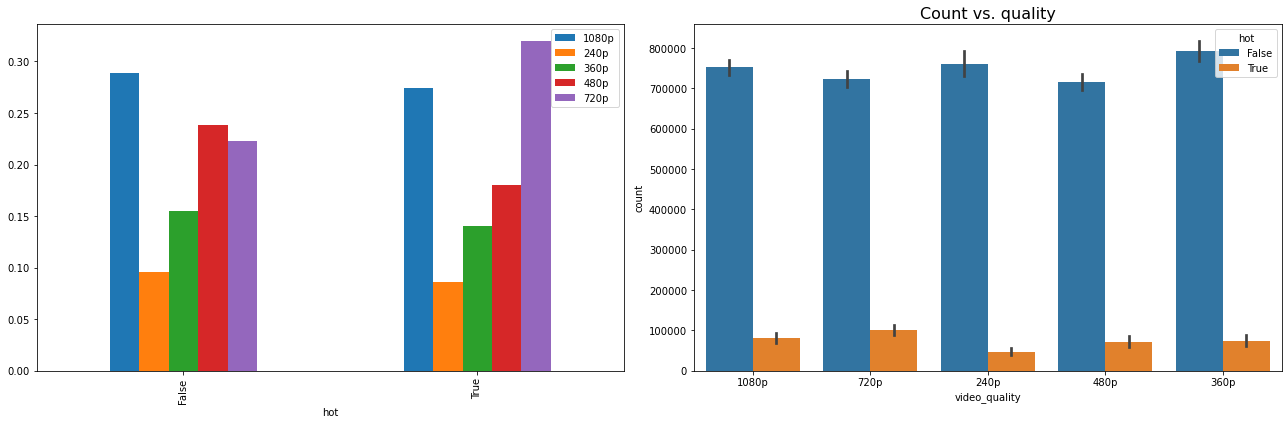

In [15]:
# visualization of quality

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
tmp = data.groupby('hot')['video_quality'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp.plot(kind='bar', ax=ax[0])

sns.barplot(x='video_quality', y='count', hue='hot', data=data, ax=ax[1])
ax[1].set_title('Count vs. quality', fontsize=16)
plt.tight_layout()
plt.show()

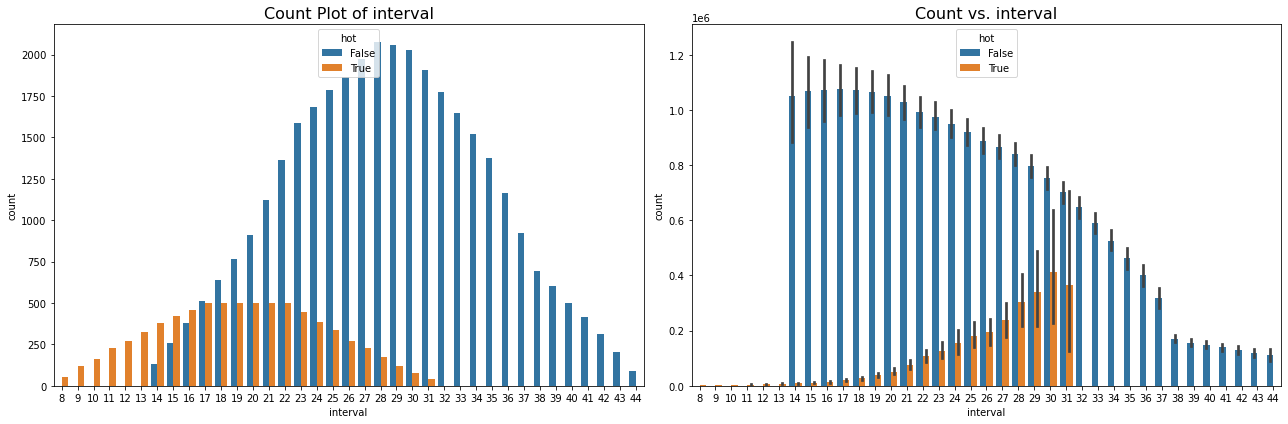

In [16]:
# visualization of interval

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='interval', hue='hot', data=data, ax=ax[0])
ax[0].set_title('Count Plot of interval', fontsize=16)

sns.barplot(x='interval', y='count', hue='hot', data=data, ax=ax[1])
ax[1].set_title('Count vs. interval', fontsize=16)
plt.tight_layout()
plt.show()

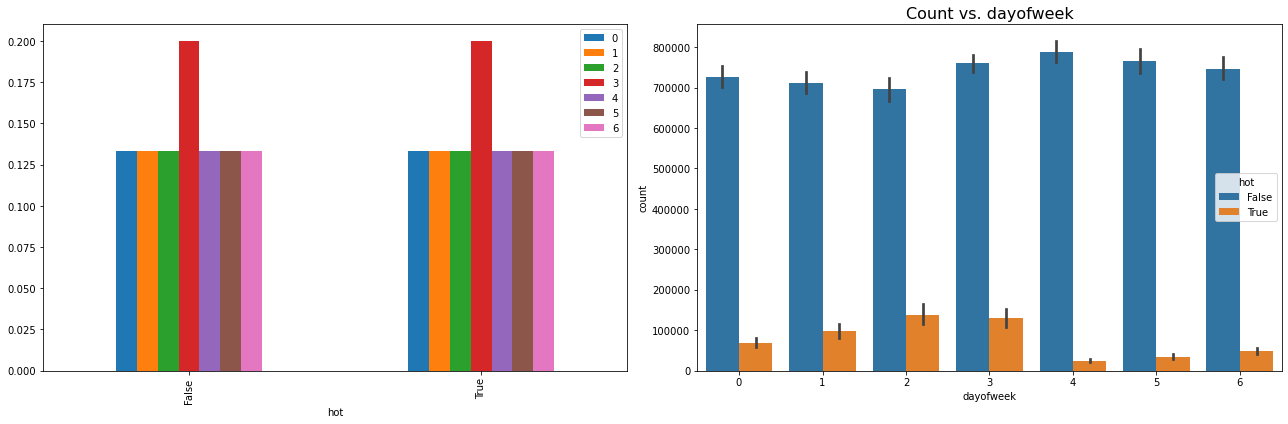

In [17]:
# visualization of dayofweek

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
tmp = data.groupby('hot')['dayofweek'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp.plot(kind='bar', ax=ax[0])

sns.barplot(x='dayofweek', y='count', hue='hot', data=data, ax=ax[1])
ax[1].set_title('Count vs. dayofweek', fontsize=16)
plt.tight_layout()
plt.show()

We can now summarize the characteristics of hot videos:

1. for the length: the hot videos normally is within 500s but not hot video has a longer watching time.

2. for the language: English is the most popular language, next is Chinese.

3. for the quality: most hot video is of 720P, but not 1080P.

4. for the inteval and dayofweek: there is no large difference between hot and not hot videos.

### Question 3: Suggestions to product teams

Since we already knew the features of hot videos, we can use some models such as decision tree or random forest classifier and put the features we identified into the models to determine the most important factors contributing to hot videos.

Next we can use those features to make our own hot videos to attract more customers to our website.

Finally, we can further consider the reasons behind some phenomenon, such as why English videos are most likely to be hot videos? Why day of week doesn't seem to have much to do with hot videos?